# Scikit-rt plotting demo

This notebook demonstrates some scikit-rt plotting capabilities, using the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)<br/>
https://doi.org/10.6084/m9.figshare.12579707.v1

If not alread present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` below.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from skrt import Patient
from skrt.core import download
from skrt.dose import sum_doses

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)

In [2]:
# Set Matplotlib runtime configuration.
# For details of Matplotlib configuration, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# Sizes are in points.

# For axes, set spacing (pad) and size of label and title
plt.rc("axes", labelpad=0, labelsize=25, titlepad=17, titlesize=25)

# Set default text charactieristics.
# Possible weight values are:
# 100, 200, 300, 400 / "normal", 500, 600, 700 / "bold", 800, 900.
plt.rc("font", family="serif", serif=["Times"], size=20, weight=400)

# Set mathematics typeface when using matplotlib's built-in fonts.
plt.rc("mathtext", fontset="dejavuserif")

# Use TeX/LaTeX for typesetting.  (This requires working TeX/LaTeX installation.)
plt.rc("text", usetex=True)

# Set fontsize for legend labels.
plt.rc("legend", fontsize=17)

# For ticks, set label size and direction ("in", "out", "inout").
plt.rc(("xtick", "ytick"), labelsize=25, direction="out")

# For major and minor ticks, set size and width.
# For major ticks, set spacing (pad) of label.
plt.rc(("xtick.major"), pad=3)
plt.rc(("xtick.major", "ytick.major"), size=9, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4.5, width=1.0)
plt.rc(("ytick.major"), pad=2)

In [3]:
# Create dictionary of default plotting options.
kwargs = {
    # Make plots interactive ("no_ui": False) or non-interactive ("no_ui": True).
    "no_ui": False,
    # Set figure size in inches.
    "figsize": (10, 6),
    # Show major ticks at specified interval (axis units).
    "major_ticks": 60,
    # Show minor ticks for specified number of intervals between major ticks.
    "minor_ticks": 5,
    # Indicate whether axis units should be mm or numbers of voxels.
    "scale_in_mm" : True,
    # Indicate whether ticks should be shown on all sides.
    "ticks_all_sides": True,
    # Specify zoom factor.
    "zoom": 2.0,
}

# Set fontsize for annotations.
# Value set via plt.rc("font", size=20) seems not to be applied consistently.
annotation_fontsize = 20

In [4]:
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))

In [5]:
# Define index for path to patient folder of interest.
idx = 0

# Read patient data.
patient = Patient(paths[idx], unsorted_dicom=True)

In [6]:
# Identify study containing ct_image, ct_structure_set, ct_dose.
# If no study contains all of these data types,
# an exception will be raised.
for study in patient.studies + [None]:
    if all(["ct" in getattr(study, f"{dtype}_types", [])
            for dtype in ["image", "structure_set", "dose"]]):
        break

if study is None:
    raise RuntimeError("No study found with required data types")

In [7]:
# Obtain reference to earliest CT image. 
im = study.ct_images[0]

# Obtain reference to earliest structure set associated with CT image.
ss = im.structure_sets[0]

# Obtain sum of image-associated doses.
dose = sum_doses(im.doses)

# Ensure that dose has same geometry as image.
dose.match_size(im)
dose.image = im

In [8]:
# Plot image with structure set overlain, and with off-image legend.

# Overlay default annotation, in black, at default position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {"color": 'yellow', "fontsize": annotation_fontsize}

# Plot image:
# sl=70 : plot slice 70;
# title="" : omit title;
# rois=ss : overlay structure set;
# colorbar=1 : show colour bar for image.
# legend=True : show legend identifying ROIs of structure set.
# legend_loc="center left" : Use centre left of legend as reference point for fixing its location.
# legend_bbox_to_anchor=(1.5, 0.5) : Coordinates of legend reference point, in system where image axes extend from 0 to 1.

im.view(init_sl=70, title="", rois=ss, colorbar=1,
        legend=True, legend_loc="center left", legend_bbox_to_anchor=(1.5, 0.5), **kwargs);

Output()

In [9]:
# Plot image with dose and structure set overlain, and with colour bars.

# Overlay user-defined annotation, in black, at default position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {"text": "(a)", "color": 'yellow', "fontsize": annotation_fontsize}

# Plot image:
# sl=60 : plot slice 60;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=ss : overlay structure set;
# colorbar=2 : show colour bars for image and overlay.
im.view(init_sl=60, title="", dose=dose, rois=ss, colorbar=2, **kwargs);

Output()

In [10]:
# Plot single slice without axis annotations.
# In contrast with plotting for no_axis_labels=True, the axes themselves are shown.

# Set tick marks to have zero size.
plt.rc(("xtick.major", "ytick.major"), size=0)
plt.rc(("xtick.minor", "ytick.minor"), size=0)

# Suppress axis and tick labels.
kwargs["no_xlabel"] = True
kwargs["no_xtick_labels"] = True
kwargs["no_ylabel"] = True
kwargs["no_ytick_labels"] = True

# Overlay default slice information, in azure, at user-defined position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {'text': None, 'color': 'azure', 'xy': (0.63, 0.93),
                            "fontsize": annotation_fontsize}

# Plot image:
# pos=-15 : plot slice at z=-15 mm;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=ss : overlay structure set;
im.view(init_pos=105, title="", dose=dose, rois=ss, **kwargs);

Output()

In [11]:
# Filter rois:
rois = ss.filtered_copy({"ctv": "ctv", "spinal cord": "cord*", "left lung" : "lung_l1", "right lung": "lung_r1"}, keep_renamed_only=True)
roi_colours = {"ctv": "lightpink", "spinal cord": "cyan", "left lung": "lime", "right lung": "yellow"}
for roi in rois:    
    roi.set_color(roi_colours[roi.name])

# For major and minor ticks, set size and width.
plt.rc(("xtick.major", "ytick.major"), size=9, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4.5, width=1.0)
    
# Set default font size - small enough that legend doesn't obscure image.
plt.rc("font", size=17)
    
# Suppress axis and tick labels for y axis.
kwargs["no_xlabel"] = False
kwargs["no_xtick_labels"] = False
kwargs["no_ylabel"] = True
kwargs["no_ytick_labels"] = True

# Show major ticks at specified interval (axis units).
kwargs["major_ticks"] = 120
# Show minor ticks at specified interval (axis units).
kwargs["minor_ticks"] = 6

# Specify zoom factor.
kwargs["zoom"] = 1.0

# Overlay default annotation, in black, at default position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {"color": 'yellow', "fontsize": annotation_fontsize}

# Plot dose:
# pos=18 : plot slice at z=18;
# title="" : omit title;
# include_image=True : underlay associated image;
# rois=rois : overlay filtered structure set;
# colorbar=2 : show colour bars for dose and underlay.
#     => Note that when plotting a dose with image underlay the order of the colour bars is reversed
#        with resect to plotting an image with dose overlay.
# legend=True : show legend identifying ROIs of structure set.
dose.view(init_pos=125, title="", include_image=True, rois=rois, colorbar=2, legend=True, **kwargs);

Output()

In [12]:
# Include axis and tick labels for both axes.
kwargs["no_xlabel"] = False
kwargs["no_xtick_labels"] = False
kwargs["no_ylabel"] = False
kwargs["no_ytick_labels"] = False

# Plot image in y-z plane:
# pos=9.1 : plot slice at x=57.6;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=rois : overlay filtered structure set;
# colorbar=0 : omit colour bars.
im.view(init_view="y-z", init_pos=57.6, title="", dose=dose, rois=rois, colorbar=0, **kwargs);

Output()

In [13]:
# Make this plot interactive.
kwargs["no_ui"] = False

# Plot image in x-z plane:
# pos=9.1 : plot slice at y=-10.7;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=rois : overlay filtered structure set;
# colorbar=0 : omit colour bars.
im.view(init_view="x-z", pos=-10.7, title="", dose=dose, rois=rois, colorbar=0, **kwargs);

Output()

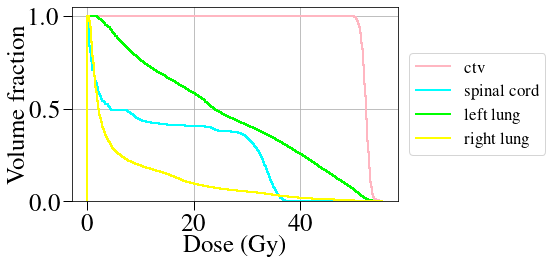

In [14]:
# Plot dose-volume histograms for ROIs.
dose.plot_dvh(rois=rois, bins=500);